In [26]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.linear_model import RidgeCV, Ridge

In [27]:
# Read in data
train = np.load('./MNIST_training_set.npy', allow_pickle=True).item() # Get items
test = np.load('./MNIST_test_set.npy', allow_pickle=True).item() # Get items
X_train, y_train = train['features'], train['labels'] # Split data
X_test, y_test = test['features'], test['labels'] # Split data
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape) # Print Shape of data

(2000, 256) (2000,) (500, 256) (500,)


In [28]:
# Create PCA Model for all components
pca = PCA() # Initialize
pca.fit(X_train); # Fit on training data

In [29]:
'''
Function to reduce dimensionality of data. Takes in PCA, data,
and number of principal components to keep
'''
def dataModeApproximation(pca_model, X_data, N_comp):
    # Reduce data and generate approximation
    all_components = np.copy(pca_model.components_) # Get all components
    X_pca = pca_model.transform(X_data) # Transform Data
    X_reduced = np.dot(X_data - pca_model.mean_, 
                       pca_model.components_[:N_comp].T) # Reduce Data
    pca_model.components_[N_comp:] = 0 # Zero out non-desired components
    X_approx = pca_model.inverse_transform(X_pca) # Inverse transform
    pca_model.components = all_components # Reset components
    
    # Return
    return X_reduced, X_approx # Return data

In [30]:
# Calculate Reduced dataset and approximation
N = 16 # Components to keep
X_train_red, X_train_red_approx = dataModeApproximation(pca, X_train, N)
X_train_red.shape

(2000, 16)

In [31]:
'''
Helper Function to Plot. Takes in data, sqrt(number of digits to plot),
and a title to use
'''
def plot_digits(X_data, N_digits, title):
    """Small helper function to plot N**2 digits."""
    fig, ax = plt.subplots(N, N, figsize=(8, 8));
    for i in range(N):
        for j in range(N):
            ax[i,j].imshow(X_data[(N)*i+j,:].reshape((16, 16)), cmap="Greys")
            ax[i,j].axis("off")
    fig.suptitle(title, fontsize=20) # Set Title

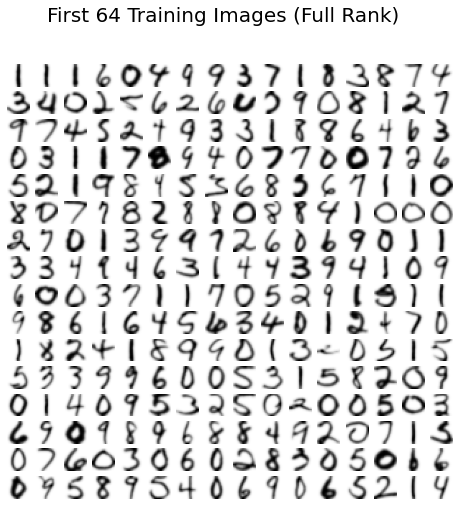

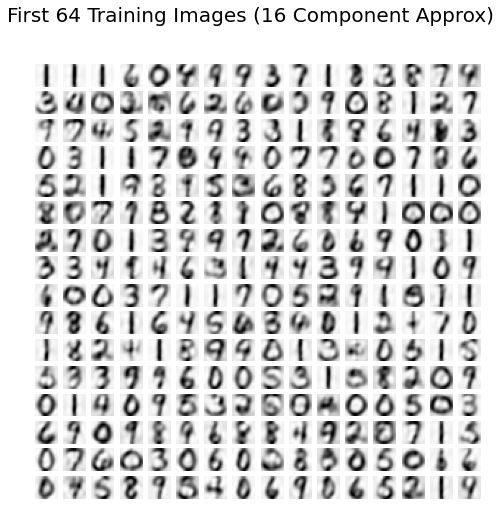

In [32]:
# Plot comparison of full rank first 64 images vs. 16 component approx
plot_digits(X_train, 8, 'First 64 Training Images (Full Rank)')
plot_digits(X_train_red_approx, 8, 'First 64 Training Images (16 Component Approx)')

In [33]:
# Get number of modes for specified variances
ratio_sums = np.cumsum(pca.explained_variance_ratio_)
num_comps = lambda pct: np.where(ratio_sums >= pct)[0].min() + 1 # Helper lambda function
var_60 = num_comps(0.60) # 60% Variance
var_80 = num_comps(0.80) # 80% Variance
var_90 = num_comps(0.90) # 90% Variance
var_95 = num_comps(0.95) # 95% Variance
var_99 = num_comps(0.99) # 99% Variance
print(var_60, var_80, var_90, var_95, var_99) # Print Results

6 13 23 34 65


In [34]:
'''
Function that extracts specified digits from MNIST dataset and creates
a dimensionally reduced dataset using only two specified digits. Takes in data, labels,
number of PCA components to use, and the digits to use. Uses 1, 2 if no digits are
specified.
'''
def reducedBinaryDigitSet(pca_model, N_comp, X_data, y_data, digits=None):
    if digits is None: # Use all digits if not specified
        digits = [1,2]
        print('No Digits Specified - Assuming 1, 2')
    
    # Update data
    idxs_to_use = np.where(np.isin(y_data, digits))[0] # Find rows of matching entries
    y_labs_new = y_data[idxs_to_use] # Get labels
    X_data_new = X_data[idxs_to_use, :] # Get Data
    y_labs_new = np.where(y_labs_new == digits[0], -1, 1) # Normalize classifier
    
    # Reduce new X_data using previous function
    X_data_new_red, _ = dataModeApproximation(pca_model, X_data_new, N_comp) 
    
    # Return data
    return X_data_new_red, y_labs_new

In [35]:
# Generate Reduced Datasets
X_train_18_red, y_train_18 = reducedBinaryDigitSet(pca, N, X_train, y_train, [1,8])
X_test_18_red, y_test_18 = reducedBinaryDigitSet(pca, N, X_test, y_test, [1,8])
print(X_train_18_red.shape, y_train_18.shape)
print(X_test_18_red.shape, y_test_18.shape)

(455, 16) (455,)
(96, 16) (96,)


In [36]:
# Generate Model Object
# We are using "leave one out cross validation"
# Note: When scoring=None, RidgeCV will use negative MSE for scoring
alphas = np.linspace(0.05, 20, 1000)
# Create Ridge CV to find best alpha, use mean_square_error for scoring
ridge_alpha = RidgeCV(alphas=alphas, scoring='neg_mean_squared_error')
ridge_alpha.fit(X_train_18_red, y_train_18) # Fit the model
alpha_best = ridge_alpha.alpha_ # Get alpha for best model

# Create Ridge Regression model using best alpha
ridge_model = Ridge(alpha=alpha_best)
ridge_model.fit(X_train_18_red, y_train_18) # Fit Model
y_train_pred = ridge_model.predict(X_train_18_red) # Predict on train data
y_test_pred = ridge_model.predict(X_test_18_red) # Predict on train data

# Will then want to calculate MSE and accuracy
# Accuracy using if < 0 -> -1, > 0 -> 1

[-1.04281272  0.96522879 -1.03523694 -1.0794912   0.85092457  0.84360551
 -0.87996125 -1.06877824 -1.05908519 -0.89519905  1.23180448  0.82381302
 -0.93508005 -0.97373514 -0.27175263 -1.02156318 -1.03969022 -1.08945753
 -0.90224426  0.61212667  1.04535373 -1.06720294  0.91768349 -0.94384446
 -1.01783279  1.24858604 -1.06873212  0.86720384 -1.05514395  0.57369737
 -1.07171843  1.08592903  1.41966331 -0.69207608 -1.02244613  0.73836219
 -1.04624179 -1.05260807 -1.00377996 -0.89780268 -0.80239635 -1.02797636
 -0.90676148 -0.9004372  -1.01283942  1.24946878 -0.56461976  0.78202551
 -1.06516779 -1.0396725  -0.65192767 -0.89934254 -0.89338465  1.00597092
 -0.94822134 -0.95458803 -0.89954353 -1.00858977  0.9296725  -0.81802627
 -1.02531007 -1.08526051 -0.30761389 -0.94228144  1.24273583  1.78270174
 -0.81086457 -1.07678097 -1.01339452 -1.02400249 -1.03948178 -1.00859725
  0.57289928  1.04257007 -0.95078818 -1.07363316 -0.94716802 -0.60138983
 -0.8728816  -1.06943969 -1.02918257 -0.98494552 -1

In [37]:
'''
Function to generate RidgeRegression Model. Takes in train data data/labels,
test data data/labels, and parameters needed to execute reducedBinaryDataset and
dataModeApproximation
'''
# def ridgeClassifierForDigits(X_train_data, y_train_data, X_test_data,)
# NOTE: I think we calculate the MSE by hand using the coeff vector of the fit
# This will be the same though, so is that right?

'\nFunction to generate RidgeRegression Model. Takes in train data data/labels,\ntest data data/labels, and parameters needed to execute reducedBinaryDataset and\ndataModeApproximation\n'